# Liberías utilizadas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
import seaborn as sns
%matplotlib inline

plt.rcParams["figure.figsize"] = [15, 5]

# 1. Carga de datos

In [143]:
active_promos = pd.read_csv('../Data/active_promos.csv')
clients_attributes = pd.read_csv('../Data/clients_attributes.csv')
executed_promos = pd.read_csv('../Data/executed_promos.csv')
sales = pd.read_csv('../Data/sales.csv',encoding = "ISO-8859-1")
test = pd.read_csv('../Data/test.csv')

# 2. Exploración de los datos (EDA)

## 2.1 Promociones activas

In [144]:
active_promos.head()

,CodigoDC,Marca,Cupo,Fecha_Desde,Fecha_Hasta,Cliente
0,297601,29,9,2018-08-06,2018-08-30,3213
1,297601,29,9,2018-08-06,2018-08-30,3795
2,297601,29,9,2018-08-06,2018-08-30,11816
3,298856,40,16,2018-08-12,2018-08-19,8444
4,309916,40,16,2018-08-12,2018-08-19,8488


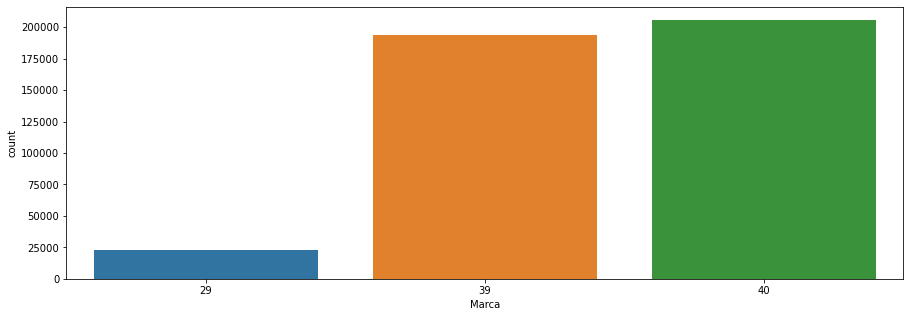

In [148]:
sns.countplot(active_promos['Marca'])

Promociones y clientes por día

In [150]:
df_aux = active_promos.groupby('Fecha_Desde').agg({'CodigoDC':'nunique','Cliente':'nunique'}).reset_index()

In [152]:
df_aux['Fecha_Desde'] = pd.to_datetime(df_aux['Fecha_Desde'])

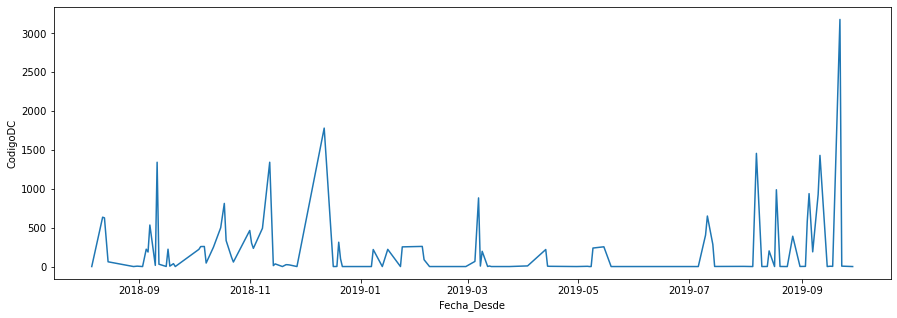

In [153]:
sns.lineplot(data=df_aux,x='Fecha_Desde',y='CodigoDC')

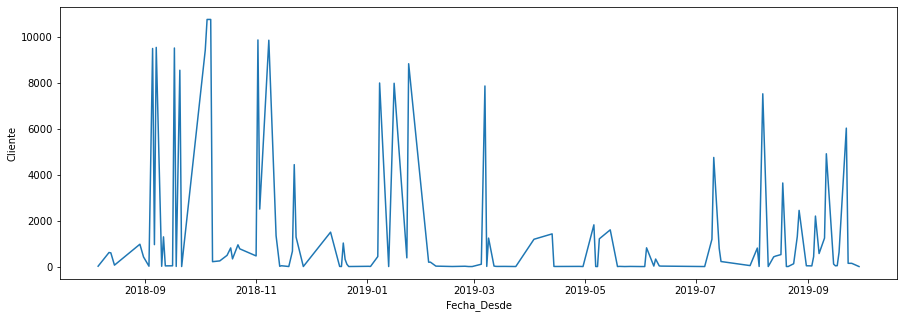

In [154]:
sns.lineplot(data=df_aux,x='Fecha_Desde',y='Cliente')

## 2.2 Atributos de los clientes

In [155]:
clients_attributes.head()

,Cliente,FechaAltaCliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF
0,1,2009-03-03,4,21,12,1,1,1
1,9,2009-03-03,4,21,9,2,3,1
2,15,2009-03-03,4,21,9,2,3,0
3,37,2009-03-03,4,21,16,2,3,1
4,43,2009-03-03,4,21,9,2,3,0


Regiones

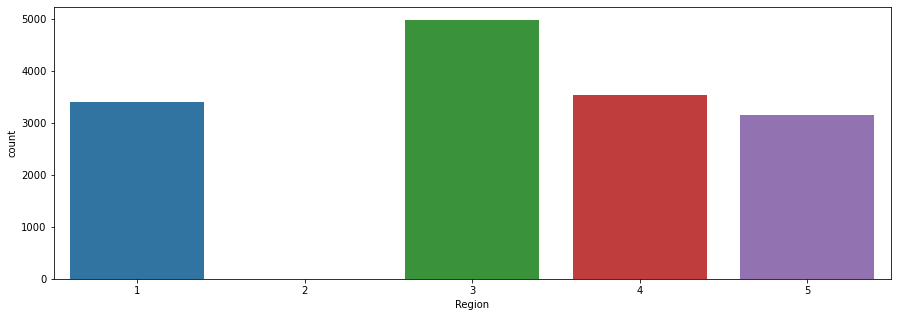

In [156]:
sns.countplot(clients_attributes['Region'])

Subcanal

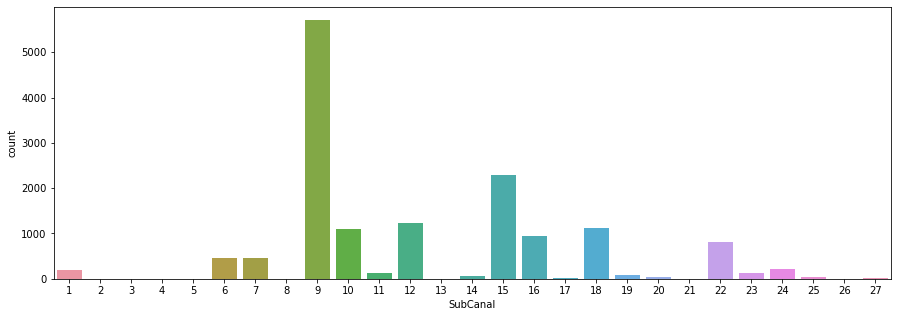

In [157]:
sns.countplot(clients_attributes['SubCanal'])

Estrato

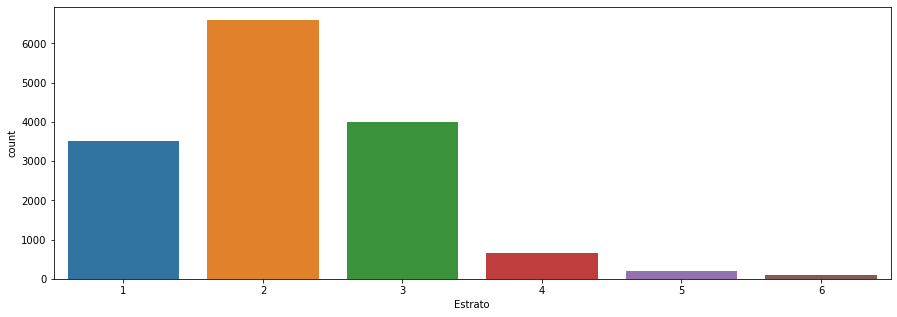

In [159]:
sns.countplot(clients_attributes['Estrato'])

## 2.3 Ventas

In [161]:
sales.head()

,Cliente,Año,Mes,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto
0,1,2018,1,2,2.0,44,10.0,6352.94,0.03,0.0
1,1,2018,1,2,4.0,18,16.0,99130.50,0.45,0.0
2,1,2018,6,2,1.0,2,6.0,11605.40,0.07,-2880.0
3,1,2018,7,1,2.0,37,34.0,1944.01,0.01,0.0
4,1,2018,8,2,1.0,2,16.0,16250.18,0.06,0.0


Periodos

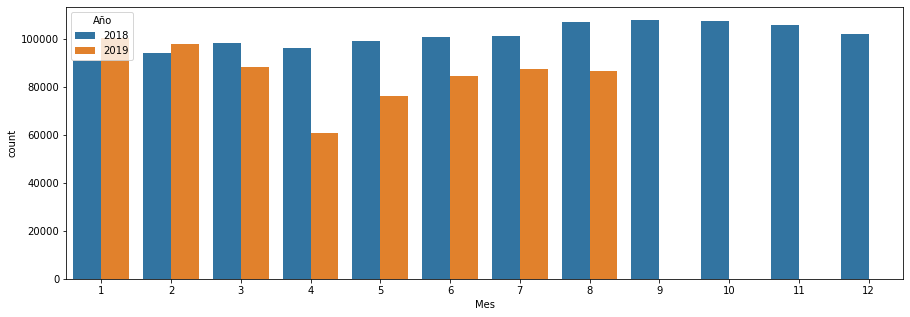

In [163]:
sns.countplot(data=sales, x='Mes', hue='Año')

Ventas por año y mes

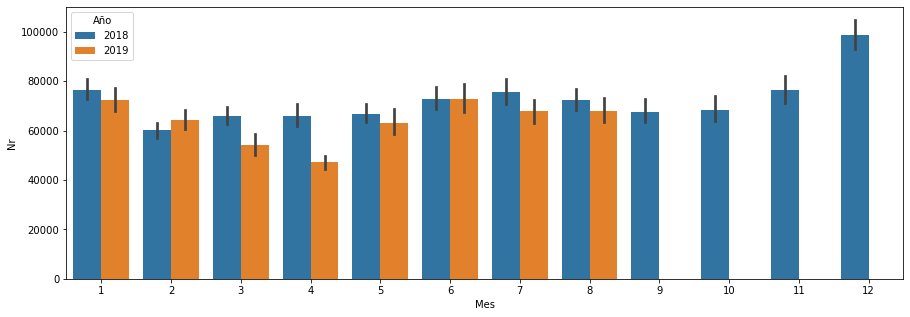

In [167]:
sns.barplot(x='Mes',y='Nr',data=sales,hue='Año')

Volumen por año y mes

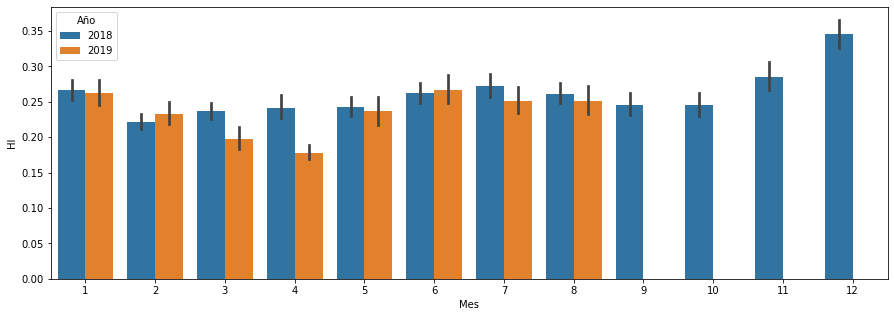

In [168]:
sns.barplot(x='Mes',y='Hl',data=sales,hue='Año')

# 3. Creación de variables (feature engineering)

## 3.1 Pre-procesamientos de datos

### 3.1.1 Creación de un catálogo de meses

Hemos creado este catálogo para etiquetar a cada mes con un número correlativo y tener facilidades para crear variables de los 3,4 o 6 últimos meses.

In [169]:
# Esta lista contendrà listas con el año, mes y el còdigo
lista_meses=[]
count=1
for anio in range(2018,2021):
    for mes in range(1,13):
        lista_meses.append([anio,mes,count])
        count += 1

Creación de un dataframe con la lista creada

In [170]:
lista_meses_df = pd.DataFrame(lista_meses,columns=['Año','Mes','Codigo_periodo'])
lista_meses_df.head()

,Año,Mes,Codigo_periodo
0,2018,1,1
1,2018,2,2
2,2018,3,3
3,2018,4,4
4,2018,5,5


### 3.1.2 Agregar año, mes y código del periodo al dataset de promos activas

Le asignamos a las fechas el formato adecuado y agregamos año y mes

In [171]:
active_promos['Fecha_Desde'] = pd.to_datetime(active_promos['Fecha_Desde'])
active_promos['Fecha_Hasta'] = pd.to_datetime(active_promos['Fecha_Hasta'])

active_promos['Año'] = active_promos['Fecha_Desde'].dt.year
active_promos['Mes'] = active_promos['Fecha_Desde'].dt.month

In [172]:
active_promos.head()

,CodigoDC,Marca,Cupo,Fecha_Desde,Fecha_Hasta,Cliente,Año,Mes
0,297601,29,9,2018-08-06,2018-08-30,3213,2018,8
1,297601,29,9,2018-08-06,2018-08-30,3795,2018,8
2,297601,29,9,2018-08-06,2018-08-30,11816,2018,8
3,298856,40,16,2018-08-12,2018-08-19,8444,2018,8
4,309916,40,16,2018-08-12,2018-08-19,8488,2018,8


También se le agrega otro identificado del tipo 201908

In [185]:
active_promos['Periodo'] = active_promos['Fecha_Desde'].apply(lambda x: str(x)[0:4]+str(x)[5:7])

In [174]:
active_promos['Periodo_ini'] = active_promos['Fecha_Desde'].apply(lambda x: str(x)[0:4]+str(x)[5:7])
active_promos['Periodo_fin'] = active_promos['Fecha_Hasta'].apply(lambda x: str(x)[0:4]+str(x)[5:7])

Convertir los periodos a enteros

In [175]:
active_promos['Periodo_ini'] = active_promos['Periodo_ini'].astype(int)
active_promos['Periodo_fin'] = active_promos['Periodo_fin'].astype(int)

Finalmente se le añade el Codigo_periodo

In [176]:
active_promos = pd.merge(active_promos,lista_meses_df,how='left', on=['Año','Mes'])

### 3.1.3 Nulos en el dataset de ventas

También le agregamos el "Codigo_periodo"

In [177]:
sales = pd.merge(sales,lista_meses_df,how='left', on=['Año','Mes'])

Eliminamos nulos en el SegmentoPrecio (son 5 registros)

In [178]:
sales = sales[~pd.isna(sales['SegmentoPrecio'])].copy()

Convertimos a entero los campos SegmentoPrecio y Cupo

In [179]:
sales['SegmentoPrecio'] = sales['SegmentoPrecio'].apply(lambda x: int(x))
sales['Cupo'] = sales['Cupo'].apply(lambda x: int(x))

### 3.1.3 Catálogo marca - cupo - SegmentoPrecio

Usaremos este catálogo para determinar el segmento del precio de la marca-cupo, se ha validado que el semgneto es único.

In [180]:
catalgo_marca_cupo_SP = sales.groupby(['Marca','Cupo','SegmentoPrecio'])['Codigo_periodo'].count().reset_index()
catalgo_marca_cupo_SP.drop('Codigo_periodo',axis=1,inplace=True)
catalgo_marca_cupo_SP.head()

,Marca,Cupo,SegmentoPrecio
0,1,30,2
1,1,35,2
2,2,5,1
3,2,6,1
4,2,10,1


## 3.2 Creación de variables de ventas

Se ha creado variables de ventas para los 6 últimos meses de los clientes con promociones activas. Para ello usaremos las siguientes funciones:

In [181]:
def cant_meses_6(m0,m1,m2,m3,m4,m5):
    """ 
    Esta función calcula la cantidad de meses en el cual el valor (ventas,
    litros, etc) no fue cero. También identifica el mes más reciente
    con el valor mayor a 0.
  
    Parameters: 
    m0: Valor del mes 0 (el más reciente).
    m1: Valor del mes 0
    m2: Valor del mes 0
    m3: Valor del mes 0
    m4: Valor del mes 0
    m5: Valor del mes 0
  
    Returns: 
    count: Cantidad de meses con valor mayor a 0.
    ultimo_mes: Mes más reciente con valor mayor a 0.
    """
    ultimo_mes = np.nan
    count = int(m0>0) + int(m1>0) + int(m2>0) + int(m3>0) + int(m4>0) + int(m5>0)
    if m0>0:
        ultimo_mes = 1
    elif m1>0:
        ultimo_mes = 2
    elif  m2>0:
        ultimo_mes = 3
    elif  m3>0:
        ultimo_mes = 4
    elif  m4>0:
        ultimo_mes = 5
    elif  m5>0:
        ultimo_mes = 6
    
    return count,ultimo_mes

In [182]:
def crear_variables_mensuales(df_var, rangos, columnas_agg):
    """ 
    Esta función usa el dataframe df_var para crear variables en 
    diversos rangos de meses de la lista "rangos" por cada columna
    de la lista columnas_agg.
  
    Parameters: 
    df_var: Dataframe con la data.
    rangos: Lista con los rangos para crear las variables.
    columnas_agg: Columnas a usar para la variables

    Returns: 
    df_var: Dataframe con las variables creadas.
    """
    print('Creando variables ...')
    for rango in rangos:
        for columna_ in columnas_agg:
            lista_columnas = []
            for j in range(rango[0],rango[1]+1):
                lista_columnas.append(columna_+str(j))
            df_var[columna_+str(rango[0])+'_'+str(rango[1])+'_Mean'] = df_var[lista_columnas].mean(axis=1)
            df_var[columna_+str(rango[0])+'_'+str(rango[1])+'_Sum'] = df_var[lista_columnas].sum(axis=1)
            df_var[columna_+str(rango[0])+'_'+str(rango[1])+'_Min'] = df_var[lista_columnas].min(axis=1)
            df_var[columna_+str(rango[0])+'_'+str(rango[1])+'_Max'] = df_var[lista_columnas].max(axis=1)
            df_var[columna_+str(rango[0])+'_'+str(rango[1])+'_STD'] = df_var[lista_columnas].std(axis=1)
            df_var[columna_+str(rango[0])+'_'+str(rango[1])+'_STD'] = df_var[lista_columnas].std(axis=1)
            if rango[1]>=3:
                df_var[columna_+str(rango[0])+'_'+str(rango[1])+'_SKEW'] = df_var[lista_columnas].skew(axis=1)
            if rango[1]>=4:
                df_var[columna_+str(rango[0])+'_'+str(rango[1])+'_KURT'] = df_var[lista_columnas].kurt(axis=1)
    print('Creando variables meses ...')             
    for columna_ in columnas_agg:
        df_var[columna_+'_Meses'] = df_var.apply(lambda x: cant_meses_6(x[columna_+'1'],x[columna_+'2'],x[columna_+'3'],x[columna_+'4'],x[columna_+'5'],x[columna_+'6'])[0],axis=1)
        df_var[columna_+'_Ult_Meses'] = df_var.apply(lambda x: cant_meses_6(x[columna_+'1'],x[columna_+'2'],x[columna_+'3'],x[columna_+'4'],x[columna_+'5'],x[columna_+'6'])[1],axis=1)

    return df_var

In [183]:
def crear_variables_sales(anio,mes):
    
    """ 
    Esta función crea diversos tipos de variables (por cliente, por cliente-producto,
    por producto, por producto-region, etc) tomando el cuenta el año y mes de target
    y considerando una historia de 6 meses.
  
    Parameters: 
    anio: Año del target.
    mes: Mes del target.

    Returns: 
    data_final: Dataframe de las variabes de venta creadas para una cosecha.
    """
    
    print('Creando variables del ',anio,mes)
    ## Identificar cosecha

    ## Obtener registros para la cosecha

    cosecha = active_promos[(active_promos['Año']==anio)&(active_promos['Mes']==mes)].copy()
    cosecha = pd.merge(cosecha,catalgo_marca_cupo_SP,how='left',on=['Marca','Cupo'])

    cosecha = cosecha.groupby(['Año','Mes','Periodo','Cliente','Marca','Cupo','SegmentoPrecio'])['Codigo_periodo'].size().reset_index()
    cosecha.drop('Codigo_periodo',axis=1,inplace=True)
    cosecha = pd.merge(cosecha, clients_attributes, how='left', on='Cliente')
    print(cosecha.shape)
    
    ## Obtener historia ventas

    codigo_perido= lista_meses_df[(lista_meses_df['Año']==anio)&(lista_meses_df['Mes']==mes)]['Codigo_periodo'].values[0]
    periodo_fin = codigo_perido-1
    periodo_inicio = codigo_perido-6
    print(codigo_perido,periodo_inicio,periodo_fin)

    sales_historia = sales[(sales['Codigo_periodo']>=periodo_inicio)&(sales['Codigo_periodo']<=periodo_fin)].copy()
    sales_historia['Dif_periodo'] = codigo_perido - sales_historia['Codigo_periodo']
    sales_historia['Nr_Hl'] = sales_historia['Nr'] / (sales_historia['Hl']*100)
    sales_historia['Producto'] = sales_historia.apply(lambda x: str(x['Marca'])+'_'+str(x['Cupo']),axis=1)

    sales_historia = pd.merge(sales_historia, clients_attributes, how='left', on='Cliente')


    ####################################################
    ##########  Variables por Cliente-Marca-Cupo
    ####################################################
    print('-----------------------------------------------------------------')
    print('Variables por Cliente-Marca-Cupo ...')
    print('-----------------------------------------------------------------')
    sales_historia_df = pd.pivot_table(sales_historia, columns=['Dif_periodo'],values=['Nr','Hl','Dcto','Nr_Hl'], index=['Cliente','Marca','Cupo'],aggfunc={'Nr': np.sum,'Hl': np.sum,'Dcto': np.sum,'Nr_Hl': np.sum},fill_value=0).reset_index()
    sales_historia_df.columns = [x[0]+'_'+str(x[1]) if x[0] not in ['Cliente','Marca','Cupo'] else x[0] for x in sales_historia_df.columns]

    ## Filtrar para evitar que tome mucho tiempo en procesar
    sales_historia_df = pd.merge(sales_historia_df,cosecha[['Cliente','Marca','Cupo']], how='inner',on=['Cliente','Marca','Cupo'] )

    rangos = [[1,2],[1,3],[1,4],[1,5],[1,6]]
    columnas_agg = ['Dcto_','Hl_','Nr_','Nr_Hl_']

    sales_historia_df = crear_variables_mensuales(sales_historia_df, rangos, columnas_agg)

    sales_historia_df.columns = ['CMC_'+ x if x not in ['Cliente','Marca','Cupo'] else x for x in sales_historia_df.columns]


    ####################################################
    ##########  Variables por Cliente
    ####################################################

    print('-----------------------------------------------------------------')
    print('Variables por Cliente ...')
    print('-----------------------------------------------------------------')

    sales_historia_cliente = pd.pivot_table(sales_historia, columns=['Dif_periodo'],values=['Nr','Hl','Dcto','Nr_Hl','Producto'], index=['Cliente'],aggfunc={'Nr': np.sum,'Hl': np.sum,'Dcto': np.sum,'Nr_Hl': np.sum, 'Producto': 'nunique'},fill_value=0).reset_index()
    sales_historia_cliente.columns = [x[0]+'_'+str(x[1]) if x[0] not in ['Cliente'] else x[0] for x in sales_historia_cliente.columns]

    rangos = [[1,2],[1,3],[1,4],[1,5],[1,6]]
    columnas_agg = ['Dcto_','Hl_','Nr_','Nr_Hl_','Producto_']

    sales_historia_cliente = crear_variables_mensuales(sales_historia_cliente, rangos, columnas_agg)
    sales_historia_cliente.columns = ['C_'+ x if x not in ['Cliente'] else x for x in sales_historia_cliente.columns]

    ####################################################
    ##########  Variables por Marca-Cupo
    ####################################################
    print('-----------------------------------------------------------------')
    print('Variables por Marca-Cupo ...')
    print('-----------------------------------------------------------------')

    sales_historia_producto = pd.pivot_table(sales_historia, columns=['Dif_periodo'],values=['Nr','Hl','Dcto','Nr_Hl','Cliente'], index=['Marca','Cupo'],aggfunc={'Nr': np.sum,'Hl': np.sum,'Dcto': np.sum,'Nr_Hl': np.sum, 'Cliente': 'nunique'},fill_value=0).reset_index()
    sales_historia_producto.columns = [x[0]+'_'+str(x[1]) if x[0] not in ['Marca','Cupo'] else x[0] for x in sales_historia_producto.columns]

    rangos = [[1,2],[1,3],[1,4],[1,5],[1,6]]
    columnas_agg = ['Dcto_','Hl_','Nr_','Nr_Hl_','Cliente_']

    sales_historia_producto = crear_variables_mensuales(sales_historia_producto, rangos, columnas_agg)
    sales_historia_producto.columns = ['MC_'+ x if x not in ['Marca','Cupo'] else x for x in sales_historia_producto.columns]


    ####################################################
    ##########  Variables cliente- SegmentoPrecio
    ####################################################

    print('-----------------------------------------------------------------')
    print('Variables cliente- SegmentoPrecio ...')
    print('-----------------------------------------------------------------')

    sales_historia_segmento_precio = pd.pivot_table(sales_historia, columns=['Dif_periodo'],values=['Nr','Hl','Dcto','Nr_Hl','Producto'], index=['Cliente','SegmentoPrecio'],aggfunc={'Nr': np.sum,'Hl': np.sum,'Dcto': np.sum,'Nr_Hl': np.sum, 'Producto': 'nunique'},fill_value=0).reset_index()
    sales_historia_segmento_precio.columns = [x[0]+'_'+str(x[1]) if x[0] not in ['Cliente','SegmentoPrecio'] else x[0] for x in sales_historia_segmento_precio.columns]

    rangos = [[1,2],[1,3],[1,4],[1,5],[1,6]]
    columnas_agg = ['Dcto_','Hl_','Nr_','Nr_Hl_','Producto_']

    sales_historia_segmento_precio = crear_variables_mensuales(sales_historia_segmento_precio, rangos, columnas_agg)
    sales_historia_segmento_precio.columns = ['SP_'+ x if x not in ['Cliente','SegmentoPrecio'] else x for x in sales_historia_segmento_precio.columns]


    ####################################################
    ##########  Variables cliente- Marca
    ####################################################

    print('-----------------------------------------------------------------')
    print('Variables cliente- Marca ...')
    print('-----------------------------------------------------------------')

    sales_historia_cliente_marca = pd.pivot_table(sales_historia, columns=['Dif_periodo'],values=['Nr','Hl','Dcto','Nr_Hl','Producto'], index=['Cliente','Marca'],aggfunc={'Nr': np.sum,'Hl': np.sum,'Dcto': np.sum,'Nr_Hl': np.sum, 'Producto': 'nunique'},fill_value=0).reset_index()
    sales_historia_cliente_marca.columns = [x[0]+'_'+str(x[1]) if x[0] not in ['Cliente','Marca'] else x[0] for x in sales_historia_cliente_marca.columns]

    rangos = [[1,2],[1,3],[1,4],[1,5],[1,6]]
    columnas_agg = ['Dcto_','Hl_','Nr_','Nr_Hl_','Producto_']

    sales_historia_cliente_marca = crear_variables_mensuales(sales_historia_cliente_marca, rangos, columnas_agg)
    sales_historia_cliente_marca.columns = ['CMarca_'+ x if x not in ['Cliente','Marca'] else x for x in sales_historia_cliente_marca.columns]

    ####################################################
    ##########  Variables cliente- Cupo
    ####################################################

    print('-----------------------------------------------------------------')
    print('Variables cliente- Cupo ...')
    print('-----------------------------------------------------------------')

    sales_historia_cliente_cupo = pd.pivot_table(sales_historia, columns=['Dif_periodo'],values=['Nr','Hl','Dcto','Nr_Hl','Producto'], index=['Cliente','Cupo'],aggfunc={'Nr': np.sum,'Hl': np.sum,'Dcto': np.sum,'Nr_Hl': np.sum, 'Producto': 'nunique'},fill_value=0).reset_index()
    sales_historia_cliente_cupo.columns = [x[0]+'_'+str(x[1]) if x[0] not in ['Cliente','Cupo'] else x[0] for x in sales_historia_cliente_cupo.columns]

    rangos = [[1,2],[1,3],[1,4],[1,5],[1,6]]
    columnas_agg = ['Dcto_','Hl_','Nr_','Nr_Hl_','Producto_']

    sales_historia_cliente_cupo = crear_variables_mensuales(sales_historia_cliente_cupo, rangos, columnas_agg)
    sales_historia_cliente_cupo.columns = ['CCupo_'+ x if x not in ['Cliente','Cupo'] else x for x in sales_historia_cliente_cupo.columns]

    ####################################################
    ##########  Variables Producto - Region
    ####################################################

    print('-----------------------------------------------------------------')
    print('Variables Producto - Region ...')
    print('-----------------------------------------------------------------')

    sales_historia_producto_region = pd.pivot_table(sales_historia, columns=['Dif_periodo'],values=['Nr','Hl','Dcto','Nr_Hl','Cliente'], index=['Marca','Cupo','Region'],aggfunc={'Nr': np.sum,'Hl': np.sum,'Dcto': np.sum,'Nr_Hl': np.sum, 'Cliente': 'nunique'},fill_value=0).reset_index()
    sales_historia_producto_region.columns = [x[0]+'_'+str(x[1]) if x[0] not in ['Marca','Cupo','Region'] else x[0] for x in sales_historia_producto_region.columns]

    rangos = [[1,2],[1,3],[1,4],[1,5],[1,6]]
    columnas_agg = ['Dcto_','Hl_','Nr_','Nr_Hl_','Cliente_']

    sales_historia_producto_region = crear_variables_mensuales(sales_historia_producto_region, rangos, columnas_agg)
    sales_historia_producto_region.columns = ['PrRg_'+ x if x not in ['Marca','Cupo','Region'] else x for x in sales_historia_producto_region.columns]

    ####################################################
    ##########  Variables Producto - Gerencia
    ####################################################

    print('-----------------------------------------------------------------')
    print('Variables Producto - Gerencia ...')
    print('-----------------------------------------------------------------')

    sales_historia_producto_gerencia = pd.pivot_table(sales_historia, columns=['Dif_periodo'],values=['Nr','Hl','Dcto','Nr_Hl','Cliente'], index=['Marca','Cupo','Gerencia'],aggfunc={'Nr': np.sum,'Hl': np.sum,'Dcto': np.sum,'Nr_Hl': np.sum, 'Cliente': 'nunique'},fill_value=0).reset_index()
    sales_historia_producto_gerencia.columns = [x[0]+'_'+str(x[1]) if x[0] not in ['Marca','Cupo','Gerencia'] else x[0] for x in sales_historia_producto_gerencia.columns]

    rangos = [[1,2],[1,3],[1,4],[1,5],[1,6]]
    columnas_agg = ['Dcto_','Hl_','Nr_','Nr_Hl_','Cliente_']

    sales_historia_producto_gerencia = crear_variables_mensuales(sales_historia_producto_gerencia, rangos, columnas_agg)
    sales_historia_producto_gerencia.columns = ['PrGe_'+ x if x not in ['Marca','Cupo','Gerencia'] else x for x in sales_historia_producto_gerencia.columns]

    ####################################################
    ##########  Variables Producto - SubCanal
    ####################################################

    print('-----------------------------------------------------------------')
    print('Variables Producto - SubCanal ...')
    print('-----------------------------------------------------------------')

    sales_historia_producto_subcanal = pd.pivot_table(sales_historia, columns=['Dif_periodo'],values=['Nr','Hl','Dcto','Nr_Hl','Cliente'], index=['Marca','Cupo','SubCanal'],aggfunc={'Nr': np.sum,'Hl': np.sum,'Dcto': np.sum,'Nr_Hl': np.sum, 'Cliente': 'nunique'},fill_value=0).reset_index()
    sales_historia_producto_subcanal.columns = [x[0]+'_'+str(x[1]) if x[0] not in ['Marca','Cupo','SubCanal'] else x[0] for x in sales_historia_producto_subcanal.columns]

    rangos = [[1,2],[1,3],[1,4],[1,5],[1,6]]
    columnas_agg = ['Dcto_','Hl_','Nr_','Nr_Hl_','Cliente_']

    sales_historia_producto_subcanal = crear_variables_mensuales(sales_historia_producto_subcanal, rangos, columnas_agg)
    sales_historia_producto_subcanal.columns = ['PrSubCanal_'+ x if x not in ['Marca','Cupo','SubCanal'] else x for x in sales_historia_producto_subcanal.columns]

    ####################################################
    ##########  Variables Producto - TipoPoblacion
    ####################################################

    print('-----------------------------------------------------------------')
    print('Variables Producto - TipoPoblacion ...')
    print('-----------------------------------------------------------------')

    sales_historia_producto_tipoPoblacion = pd.pivot_table(sales_historia, columns=['Dif_periodo'],values=['Nr','Hl','Dcto','Nr_Hl','Cliente'], index=['Marca','Cupo','TipoPoblacion'],aggfunc={'Nr': np.sum,'Hl': np.sum,'Dcto': np.sum,'Nr_Hl': np.sum, 'Cliente': 'nunique'},fill_value=0).reset_index()
    sales_historia_producto_tipoPoblacion.columns = [x[0]+'_'+str(x[1]) if x[0] not in ['Marca','Cupo','TipoPoblacion'] else x[0] for x in sales_historia_producto_tipoPoblacion.columns]

    rangos = [[1,2],[1,3],[1,4],[1,5],[1,6]]
    columnas_agg = ['Dcto_','Hl_','Nr_','Nr_Hl_','Cliente_']

    sales_historia_producto_tipoPoblacion = crear_variables_mensuales(sales_historia_producto_tipoPoblacion, rangos, columnas_agg)
    sales_historia_producto_tipoPoblacion.columns = ['PrTipoPob_'+ x if x not in ['Marca','Cupo','TipoPoblacion'] else x for x in sales_historia_producto_tipoPoblacion.columns]

    ####################################################
    ##########  Variables Producto - Estrato
    ####################################################

    print('-----------------------------------------------------------------')
    print('Variables Producto - Estrato ...')
    print('-----------------------------------------------------------------')

    sales_historia_producto_estrato = pd.pivot_table(sales_historia, columns=['Dif_periodo'],values=['Nr','Hl','Dcto','Nr_Hl','Cliente'], index=['Marca','Cupo','Estrato'],aggfunc={'Nr': np.sum,'Hl': np.sum,'Dcto': np.sum,'Nr_Hl': np.sum, 'Cliente': 'nunique'},fill_value=0).reset_index()
    sales_historia_producto_estrato.columns = [x[0]+'_'+str(x[1]) if x[0] not in ['Marca','Cupo','Estrato'] else x[0] for x in sales_historia_producto_estrato.columns]

    rangos = [[1,2],[1,3],[1,4],[1,5],[1,6]]
    columnas_agg = ['Dcto_','Hl_','Nr_','Nr_Hl_','Cliente_']

    sales_historia_producto_estrato = crear_variables_mensuales(sales_historia_producto_estrato, rangos, columnas_agg)
    sales_historia_producto_estrato.columns = ['PrEst_'+ x if x not in ['Marca','Cupo','Estrato'] else x for x in sales_historia_producto_estrato.columns]

    ####################################################
    ##########  Variables Producto - EF
    ####################################################

    print('-----------------------------------------------------------------')
    print('Variables Producto - EF ...')
    print('-----------------------------------------------------------------')

    sales_historia_producto_ef = pd.pivot_table(sales_historia, columns=['Dif_periodo'],values=['Nr','Hl','Dcto','Nr_Hl','Cliente'], index=['Marca','Cupo','EF'],aggfunc={'Nr': np.sum,'Hl': np.sum,'Dcto': np.sum,'Nr_Hl': np.sum, 'Cliente': 'nunique'},fill_value=0).reset_index()
    sales_historia_producto_ef.columns = [x[0]+'_'+str(x[1]) if x[0] not in ['Marca','Cupo','EF'] else x[0] for x in sales_historia_producto_ef.columns]

    rangos = [[1,2],[1,3],[1,4],[1,5],[1,6]]
    columnas_agg = ['Dcto_','Hl_','Nr_','Nr_Hl_','Cliente_']

    sales_historia_producto_ef = crear_variables_mensuales(sales_historia_producto_ef, rangos, columnas_agg)
    sales_historia_producto_ef.columns = ['PrEF_'+ x if x not in ['Marca','Cupo','EF'] else x for x in sales_historia_producto_ef.columns]

    ####################################################
    ##########  Unir todo
    ####################################################

    data_final = pd.merge(cosecha,sales_historia_df, how='left', on=['Cliente','Marca','Cupo'])
    data_final = pd.merge(data_final,sales_historia_cliente, how='left', on=['Cliente'])
    data_final = pd.merge(data_final,sales_historia_producto, how='left', on=['Marca','Cupo'])
    data_final = pd.merge(data_final,sales_historia_segmento_precio, how='left', on=['Cliente','SegmentoPrecio'])

    data_final = pd.merge(data_final,sales_historia_cliente_marca, how='left', on=['Cliente','Marca'])
    data_final = pd.merge(data_final,sales_historia_cliente_cupo, how='left', on=['Cliente','Cupo'])
    data_final = pd.merge(data_final,sales_historia_producto_region, how='left', on=['Marca','Cupo','Region'])
    data_final = pd.merge(data_final,sales_historia_producto_gerencia, how='left', on=['Marca','Cupo','Gerencia'])
    data_final = pd.merge(data_final,sales_historia_producto_subcanal, how='left', on=['Marca','Cupo','SubCanal'])
    data_final = pd.merge(data_final,sales_historia_producto_tipoPoblacion, how='left', on=['Marca','Cupo','TipoPoblacion'])
    data_final = pd.merge(data_final,sales_historia_producto_estrato, how='left', on=['Marca','Cupo','Estrato'])
    data_final = pd.merge(data_final,sales_historia_producto_ef, how='left', on=['Marca','Cupo','EF'])
    return data_final

Creamos nuestras variables de venta por cosechas (el procesamiento puede demorar en realizarse).

In [186]:
data_final_202009 = crear_variables_sales(2019,9)

Creando variables del  2019 9
(16870, 14)
21 15 20
-----------------------------------------------------------------
Variables por Cliente-Marca-Cupo ...
-----------------------------------------------------------------
Creando variables ...
Creando variables meses ...
-----------------------------------------------------------------
Variables por Cliente ...
-----------------------------------------------------------------
Creando variables ...
Creando variables meses ...
-----------------------------------------------------------------
Variables por Marca-Cupo ...
-----------------------------------------------------------------
Creando variables ...
Creando variables meses ...
-----------------------------------------------------------------
Variables cliente- SegmentoPrecio ...
-----------------------------------------------------------------
Creando variables ...
Creando variables meses ...
-----------------------------------------------------------------
Variables cliente- Marca 

In [187]:
data_final_202009.head()

,Año,Mes,Periodo,Cliente,Marca,Cupo,SegmentoPrecio,FechaAltaCliente,Region,Gerencia,...,PrEF_Dcto__Meses,PrEF_Dcto__Ult_Meses,PrEF_Hl__Meses,PrEF_Hl__Ult_Meses,PrEF_Nr__Meses,PrEF_Nr__Ult_Meses,PrEF_Nr_Hl__Meses,PrEF_Nr_Hl__Ult_Meses,PrEF_Cliente__Meses,PrEF_Cliente__Ult_Meses
0,2019,9,201909,1,29,9,4,2009-03-03,4,21,...,0,NaN,6,1.0,6,1,6,1,6,1
1,2019,9,201909,1,39,20,1,2009-03-03,4,21,...,0,NaN,6,1.0,6,1,6,1,6,1
2,2019,9,201909,1,40,16,1,2009-03-03,4,21,...,0,NaN,6,1.0,6,1,6,1,6,1
3,2019,9,201909,2,29,9,4,2009-03-03,4,21,...,0,NaN,6,1.0,6,1,6,1,6,1
4,2019,9,201909,6,29,9,4,2009-03-03,4,21,...,0,NaN,6,1.0,6,1,6,1,6,1


In [ ]:
data_final_202008 = crear_variables_sales(2019,8)
data_final_202007 = crear_variables_sales(2019,7)
data_final_202006 = crear_variables_sales(2019,6)
data_final_202005 = crear_variables_sales(2019,5)
data_final_202004 = crear_variables_sales(2019,4)
data_final_202003 = crear_variables_sales(2019,3)
data_final_202002 = crear_variables_sales(2019,2)

Unir

In [ ]:
data_final_concat = pd.concat([data_final_202002,data_final_202003,data_final_202004,data_final_202005,data_final_202006,data_final_202007,data_final_202008,data_final_202009])

Guardar para no volver a procesar

In [ ]:
data_final_concat.to_csv('../Data/Matriz_v3.csv',sep='|',index=False)

Importar el dataset

In [23]:
data_final_concat = pd.read_csv('../Data/Matriz_v3.csv',sep='|')

## 3.2 Creación de variables de promociones

Primero creamos un catàlogo con los periodos

In [24]:
Periodo = pd.DataFrame(active_promos['Periodo_ini'].drop_duplicates())
Periodo['nro_periodo'] = 201910 - Periodo['Periodo_ini']
Periodo.loc[:,'nro_periodo'] = Periodo.loc[:,'nro_periodo'].apply(lambda x : x - 88 if x > 10 else x)

Data de promos activas, eliminamos duplicados por periodo

In [26]:
data = active_promos[['CodigoDC', 'Cliente','Marca','Cupo','Periodo_ini']].drop_duplicates()

In [27]:
data = active_promos[['Cliente','Marca','Cupo','Periodo_ini']].drop_duplicates()

In [28]:
data = pd.merge ( data , Periodo , how = 'inner' , on = ['Periodo_ini'])

In [30]:
data.head()

,Cliente,Marca,Cupo,Periodo_ini,nro_periodo
0,3213,29,9,201808,14
1,3795,29,9,201808,14
2,11816,29,9,201808,14
3,8444,40,16,201808,14
4,8488,40,16,201808,14


Dar formato al dataframe de promociones activas.

In [33]:
active_promos = pd.merge ( active_promos , Periodo , how = 'inner' , on = ['Periodo_ini'])

Formato fecha

In [34]:
active_promos['Fecha_Desde'] = active_promos['Fecha_Desde'].astype('datetime64[ns]')
active_promos['Fecha_Hasta'] = active_promos['Fecha_Hasta'].astype('datetime64[ns]')

Duración de la campaña

In [35]:
active_promos['duracion_campaña'] = (active_promos['Fecha_Hasta'] - active_promos['Fecha_Desde']).dt.days

Función para crear variables agregadas con las historia.

In [71]:
def agg_hist (df , var , var_agg , agg, suf, flag_tiempo):
    """
    Esta función crea variables de promociones activas y ejecutadas por cliente-marca, marca, cliente, etc., que serán 
    variables agregadas (sum, avg, count, mean, std) basadas en el 1er mes, 3er mes y
    6to mes.
    El cálculo se realiza dependiendo del periodo (construido según el mes año y mes) 
    considerando últimos 6 meses de historia.
    
    Parámetros:
    df : Dataframe sobre la cual se realiza el cálculo de variables (active_promos, 
    executed_promos)
    
    var : Variable sobre la que se quiere realizar el tratamiento (cliente-marca , 
    cliente, marca, etc)
    
    agg : Flag que nos indica si el tratamiento lo realizaremos en base al conteo (Ej: cantidad de promociones) o basados 
    en la suma (Ej: suma de duración de campaña).
          
    suf : Es el sufijo que se agregará al nombre de las columnas
    
    flag_tiempo: Flag que nos indica si el cálculo de agregados (sum, avg, count, 
    mean, std) se realizarán sobre el mismo mes del corte (Dataset : promociones 
    activas ) o sobre 1 mes previo(Dataset : promociones ejecutadas)
         
    Returns: 
    df_agg: Dataframe de las variabes de venta creadas.
    """    
    df_agg = pd.DataFrame()
    
    j = flag_tiempo
    
    for i in range (1,10):

        temp = df[(df.nro_periodo >= i  + j) & (df.nro_periodo < i + 6  + j)].copy()
        
        temp.loc[:, 'Periodo'] = temp.loc[:, 'nro_periodo'].apply(lambda x : suf + 'Mes_' +  str(x - i + 1 - j))

        if agg == 0:
            temp = pd.DataFrame(temp.groupby(var + ['Periodo'])[var_agg].sum()).reset_index()
        elif agg == 1 :
            temp = pd.DataFrame(temp.groupby(var + ['Periodo'])[var_agg].count()).reset_index()
        else :
            temp = pd.DataFrame(temp.groupby(var + ['Periodo'])[var_agg].mean()).reset_index()
            
        temp.loc[:, 'nro_periodo'] = i 
        
        temp2 = temp.pivot_table(values=var_agg, index= var+ ['nro_periodo']  , columns='Periodo', aggfunc='sum').reset_index()
        
        temp2.fillna(0, inplace = True)
        
        df_agg = pd.concat([df_agg, temp2])
    
    df_agg.loc[ df_agg[suf + 'Mes_6'] > 0 ,suf + 'Pri_Per'] = 6
    df_agg.loc[ df_agg[suf + 'Mes_5'] > 0 ,suf + 'Pri_Per'] = 5
    df_agg.loc[ df_agg[suf + 'Mes_4'] > 0 ,suf + 'Pri_Per'] = 4
    df_agg.loc[ df_agg[suf + 'Mes_3'] > 0 ,suf + 'Pri_Per'] = 3
    df_agg.loc[ df_agg[suf + 'Mes_2'] > 0 ,suf + 'Pri_Per'] = 2
    df_agg.loc[ df_agg[suf + 'Mes_1'] > 0 ,suf + 'Pri_Per'] = 1
    
    df_agg[suf + 'Count_3m'] = df_agg[suf + 'Mes_1'].apply(lambda x : 1 if x  > 0 else 0) + df_agg[suf + 'Mes_2'].apply(lambda x : 1 if x  > 0 else 0) + df_agg[suf + 'Mes_3'].apply(lambda x : 1 if x  > 0 else 0)
    df_agg[suf + 'Avg_3m'] = df_agg[[suf + 'Mes_1',suf + 'Mes_2',suf + 'Mes_3']].mean(axis = 1)
    df_agg[suf + 'Max_3m'] = df_agg[[suf + 'Mes_1',suf + 'Mes_2',suf + 'Mes_3']].max(axis = 1)
    df_agg[suf + 'Min_3m'] = df_agg[[suf + 'Mes_1',suf + 'Mes_2',suf + 'Mes_3']].min(axis = 1)
    df_agg[suf + 'Std_3m'] = df_agg[[suf + 'Mes_1',suf + 'Mes_2',suf + 'Mes_3']].std(axis = 1)
    df_agg[suf + 'Sum_3m'] = df_agg[[suf + 'Mes_1',suf + 'Mes_2',suf + 'Mes_3']].sum(axis = 1)
    
    df_agg[suf + 'Count_6m'] = df_agg[suf + 'Mes_1'].apply(lambda x : 1 if x  > 0 else 0) + df_agg[suf + 'Mes_2'].apply(lambda x : 1 if x  > 0 else 0) + df_agg[suf + 'Mes_3'].apply(lambda x : 1 if x  > 0 else 0) + df_agg[suf + 'Mes_4'].apply(lambda x : 1 if x  > 0 else 0) + df_agg[suf + 'Mes_5'].apply(lambda x : 1 if x  > 0 else 0) + df_agg[suf + 'Mes_6'].apply(lambda x : 1 if x  > 0 else 0)
    df_agg[suf + 'Avg_6m'] = df_agg[[suf + 'Mes_1',suf + 'Mes_2',suf + 'Mes_3',suf + 'Mes_4',suf + 'Mes_5',suf + 'Mes_6']].mean(axis = 1)
    df_agg[suf + 'Max_6m'] = df_agg[[suf + 'Mes_1',suf + 'Mes_2',suf + 'Mes_3',suf + 'Mes_4',suf + 'Mes_5',suf + 'Mes_6']].max(axis = 1)
    df_agg[suf + 'Min_6m'] = df_agg[[suf + 'Mes_1',suf + 'Mes_2',suf + 'Mes_3',suf + 'Mes_4',suf + 'Mes_5',suf + 'Mes_6']].min(axis = 1)
    df_agg[suf + 'Std_6m'] = df_agg[[suf + 'Mes_1',suf + 'Mes_2',suf + 'Mes_3',suf + 'Mes_4',suf + 'Mes_5',suf + 'Mes_6']].std(axis = 1)
    df_agg[suf + 'Sum_6m'] = df_agg[[suf + 'Mes_1',suf + 'Mes_2',suf + 'Mes_3',suf + 'Mes_4',suf + 'Mes_5',suf + 'Mes_6']].sum(axis = 1)

    
    df_agg = df_agg[ var + ['nro_periodo', suf + 'Mes_1', suf + 'Pri_Per', suf + 'Count_3m', suf + 'Avg_3m', suf + 'Max_3m', suf + 'Min_3m', suf + 'Std_3m',suf + 'Sum_3m', suf +  'Count_6m', suf + 'Avg_6m',suf + 'Max_6m', suf + 'Min_6m' , suf + 'Std_6m', suf + 'Sum_6m']]
    
    return df_agg

Variables cliente y cantidad de promociones

In [40]:
ap_cliente_qtyProm = agg_hist(active_promos , ['Cliente'] , 'CodigoDC', 1, 'Cli_Camp_', 0)

Variables marca y cantidad de promociones

In [41]:
ap_marca_qtyProm = agg_hist(active_promos , ['Marca'] , 'CodigoDC',1,'Mar_Camp_', 0)

Variables cliente y marca

In [42]:
ap_clientexmarca_qtyProm = agg_hist(active_promos , ['Marca' ,'Cliente'], 'CodigoDC',1,'ClixMar_Camp_', 0)

Variables de duración

In [43]:
ap_cliente_SumDur = agg_hist(active_promos , ['Cliente'] , 'duracion_campaña',0,'Cli_Dur_',0)
ap_marca_SumDur = agg_hist(active_promos , ['Marca'] , 'duracion_campaña',0,'Mar_Dur_',0)
ap_clientexmarca_SumDur = agg_hist(active_promos , ['Marca' ,'Cliente'], 'duracion_campaña',0,'ClixMar_Dur_',0)

Variables cliente y promociones

In [44]:
ap_cliente_Prom = agg_hist(active_promos , ['CodigoDC'] , 'Cliente',1,'Camp_',0)

## 3.3 Variables considerando días festivos

Dataframe con el listado de fechas festivas

In [45]:
dias_festivos = pd.DataFrame({'nro_periodo': [1,2,2,3,3,4,4,5,5,5,6,6,7,8,8,9,9,10,10,10,11,11,12,12,13,14,14], 
                   'Dia_Festivo': ['2019-10-08','2019-10-08','2019-08-30','2019-08-30','2019-07-28','2019-07-28','2019-06-16','2019-06-6','2019-05-12','2019-05-01','2019-05-01','2019-04-09','2019-04-09','2019-04-09','2019-02-14','2019-2-14','2019-01-01','2019-01-01','2018-12-25','2018-12-08','2018-12-08','2018-11-01','2018-11-01','2018-10-08','2018-10-08','2018-10-08','2018-08-30']})

In [47]:
dias_festivos['Dia_Festivo'] = dias_festivos['Dia_Festivo'].astype('datetime64[ns]')

Copia de la data de promociones

In [48]:
promo_dias_festivos = active_promos[['CodigoDC','Cliente','Marca','Cupo','Fecha_Desde','nro_periodo']].copy()

Cruce con días festivos y calcular la diferencia de días

In [49]:
promo_dias_festivos = pd.merge(promo_dias_festivos, dias_festivos, how = 'left' , on = 'nro_periodo')
promo_dias_festivos['dif_dias'] = (promo_dias_festivos['Dia_Festivo'] - promo_dias_festivos['Fecha_Desde']).dt.days
promo_dias_festivos.head()

,CodigoDC,Cliente,Marca,Cupo,Fecha_Desde,nro_periodo,Dia_Festivo,dif_dias
0,297601,3213,29,9,2018-08-06,14,2018-10-08,63
1,297601,3213,29,9,2018-08-06,14,2018-08-30,24
2,297601,3795,29,9,2018-08-06,14,2018-10-08,63
3,297601,3795,29,9,2018-08-06,14,2018-08-30,24
4,297601,11816,29,9,2018-08-06,14,2018-10-08,63


Solo vamos a considerar los días festivos que sucederan, los que ya pasaron luego de la promoción

In [50]:
promo_dias_festivos = promo_dias_festivos[promo_dias_festivos.dif_dias >0].copy()

Y vamos a considerar la menor diferencia, es decir el día festivo más cercano

In [51]:
promo_dias_festivos["rank"] = promo_dias_festivos.groupby(['Cliente','CodigoDC','Marca','Cupo'])["dif_dias"].rank("dense", ascending=True)
promo_dias_festivos = promo_dias_festivos[promo_dias_festivos['rank'] == 1].copy()

In [52]:
promo_dias_festivos.head()

,CodigoDC,Cliente,Marca,Cupo,Fecha_Desde,nro_periodo,Dia_Festivo,dif_dias,rank
1,297601,3213,29,9,2018-08-06,14,2018-08-30,24,1.0
3,297601,3795,29,9,2018-08-06,14,2018-08-30,24,1.0
5,297601,11816,29,9,2018-08-06,14,2018-08-30,24,1.0
7,298856,8444,40,16,2018-08-12,14,2018-08-30,18,1.0
9,309916,8488,40,16,2018-08-12,14,2018-08-30,18,1.0


Variables por días festivos

In [53]:
dias_festivos_agg = agg_hist (promo_dias_festivos , ['Cliente','Marca'] , 'dif_dias',2,'Dur_',0)

## 3.4 Variables de los atributos del cliente

In [54]:
clients_attributes['FechaAltaCliente'] = clients_attributes['FechaAltaCliente'].astype('datetime64[ns]')

La región dos pasará a ser región 3 (solo hay 3 clientes)

In [56]:
clients_attributes.Region.value_counts()

3    4981
4    3531
1    3397
5    3157
2       3
Name: Region, dtype: int64

In [57]:
clients_attributes.loc[clients_attributes.Region == 2, 'Region'] = 3

Subcanal

In [58]:
clients_attributes.SubCanal.value_counts()/len(clients_attributes) # Las 9 primeras suman el 95%

9     0.379123
15    0.152167
12    0.082421
18    0.074391
10    0.072732
16    0.062512
22    0.054483
6     0.031057
7     0.030924
24    0.014135
1     0.013272
11    0.008627
23    0.008030
19    0.005442
14    0.004048
25    0.002124
20    0.001924
17    0.001062
27    0.000531
26    0.000199
4     0.000199
3     0.000133
2     0.000133
8     0.000133
5     0.000066
13    0.000066
21    0.000066
Name: SubCanal, dtype: float64

In [59]:
clients_attributes.loc[~clients_attributes.SubCanal.isin([9,15,12,10,16,18,22,6,7]), 'SubCanal'] = 100

Dummies de variables categóricas

In [60]:
clients_attributes_vf = pd.get_dummies(clients_attributes, columns=['Region','SubCanal','TipoPoblacion','EF'])

## 3.5 Construción del Target

Son aquellos con promoción ejecutada

In [61]:
executed_promos['TARGET'] = 1

Cruzamos con las promociones activas

In [62]:
Promo_Exitosas = pd.merge(active_promos ,executed_promos , how = 'inner' , on = ['CodigoDC','Cliente','Marca','Cupo'] )

Variables de promociones ejecutadas

In [63]:
Promo_Exitosas_cliente = agg_hist (Promo_Exitosas , ['Cliente'] , 'CodigoDC',1,'Exi_Cli_',1)
Promo_Exitosas_clientexmarca = agg_hist (Promo_Exitosas , ['Marca' ,'Cliente'], 'CodigoDC',1,'Exi_ClixMar_', 1)
Promo_Exitosas_marca = agg_hist (Promo_Exitosas , ['Marca'], 'CodigoDC',1,'Exi_Mar_', 1)

**Base del Target**

In [64]:
Base_Target = Promo_Exitosas[['Cliente','Marca', 'nro_periodo','TARGET']].drop_duplicates()

## 3.6 Unir el universo de variables creadas

In [65]:
datafinal = pd.merge(data ,ap_cliente_qtyProm , how = 'inner' , on = ['Cliente','nro_periodo'] )
datafinal = pd.merge(datafinal ,ap_marca_qtyProm , how = 'inner' , on = ['Marca','nro_periodo'] )
datafinal = pd.merge(datafinal ,ap_clientexmarca_qtyProm , how = 'inner' , on = ['Cliente', 'Marca','nro_periodo'] )
datafinal = pd.merge(datafinal ,ap_cliente_SumDur , how = 'inner' , on = ['Cliente','nro_periodo'] )
datafinal = pd.merge(datafinal ,ap_marca_SumDur , how = 'inner' , on = ['Marca','nro_periodo']  )
datafinal = pd.merge(datafinal ,ap_clientexmarca_SumDur , how = 'inner' , on = ['Cliente', 'Marca','nro_periodo']  )
datafinal = pd.merge(datafinal ,dias_festivos_agg , how = 'inner' , on = ['Cliente','Marca','nro_periodo']  )
datafinal = pd.merge(datafinal ,Promo_Exitosas_cliente , how = 'left' , on = ['Cliente','nro_periodo']  )
datafinal = pd.merge(datafinal ,Promo_Exitosas_clientexmarca , how = 'left' , on = ['Marca' ,'Cliente','nro_periodo']  )
datafinal = pd.merge(datafinal ,Promo_Exitosas_marca , how = 'left' , on = ['Marca','nro_periodo']  )
datafinal = pd.merge(datafinal ,clients_attributes_vf , how = 'left' , on = ['Cliente'] )

Antiguedad

In [66]:
datafinal['Fecha'] = pd.to_datetime(datafinal['Periodo_ini'].astype(str)+ '01', format='%Y%m%d')
datafinal['Antiguedad'] = ((datafinal['Fecha'] - datafinal['FechaAltaCliente']).dt.days)

Eliminar fechas

In [67]:
datafinal.drop(['Fecha','FechaAltaCliente'], axis=1, inplace = True)

Unión con el target

In [68]:
datafinal = pd.merge(datafinal ,Base_Target , how = 'left' , on = ['Cliente','Marca','nro_periodo'] )

In [69]:
datafinal.fillna(0, inplace = True)

Guardar 

In [70]:
datafinal.to_csv('Data_v2.csv',index=False)

Unión con las variables de ventas

In [74]:
data_final_concat.rename(columns={'Periodo': 'Periodo_ini'}, inplace = True)

In [78]:
data_modelo = pd.merge(datafinal ,data_final_concat.drop(['Año','Mes','FechaAltaCliente','Region','Gerencia','SubCanal','TipoPoblacion','Estrato','EF'],axis=1) , how= 'inner', on = ['Cliente','Marca','Cupo','Periodo_ini'])

In [79]:
datafinal.shape, data_modelo.shape

((98564, 167), (79590, 2528))

# 4. Modelos de Machine Learning

Función para crear el dataframe para el submit

In [97]:
def generar_submit(lista_predicciones):
    """ 
    Esta recibe las predicciones y devuelve un csv para realizar el submit
  
    Parameters: 
    lista_predicciones: Listado de predicciones para el test.
  
    Returns: 
    submit: Dataframe con las probabilidades solicitadas para el submit
    """
    submit = data_modelo[data_modelo['Periodo_ini']==201909][['Cliente','Marca','Cupo']].copy()
    submit['predict'] = lista_predicciones
    submit = pd.merge(test,submit,how='left',on=['Cliente','Marca','Cupo'] )
    submit.drop('Ejecuto_Promo',axis=1,inplace=True)
    submit.rename(columns={'predict':'Ejecuto_Promo'},inplace=True)
    return submit

## 4.1 LigthGBM

In [86]:
import lightgbm as lgb

Definimos nuestro X e y

In [83]:
X = data_modelo[data_modelo['Periodo_ini']<201909].drop(['Cliente','Marca','Cupo','Periodo_ini','nro_periodo','TARGET','Gerencia'],axis=1).copy()
y = data_modelo[data_modelo['Periodo_ini']<201909]['TARGET'].copy()

In [ ]:
Dataset para la predicción del submit

In [98]:
X_predict = data_modelo[data_modelo['Periodo_ini']==201909][X.columns].copy()

Partimos la data en train y test

In [84]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

Creamos el dataset

In [87]:
train_data = lgb.Dataset(X_train , label=y_train)
test_data = lgb.Dataset(X_test , label=y_test)

Parámetros

In [90]:
parameters = {
    'boosting_type': 'gbdt',
          'max_depth' : 4,
          'objective': 'binary',
          'nthread': 6, 
          'num_leaves': 64,
          'learning_rate': 0.01,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.85,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'feature_fraction': 0.85,
          'bagging_fraction': 0.85,
          'num_class' : 1,
          'is_unbalance': 'true',
          'metric' : 'auc',
          'verbose': -1,
          
}

Entrenamiento

In [91]:
modelo_lgb = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=2000,
                       early_stopping_rounds=100, verbose_eval=100)

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=0.85 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=0.85 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=0.85 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1 will be ignored. Current value: bagging_fraction=0.85
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.913028
[200]	valid_0's auc: 0.915019
[300]	valid_0's auc: 0.916077
[400]	valid_0's auc: 0.916835
[500]	valid_0's auc: 0.917503
[600]	valid_0's auc: 0.917884
[700]	valid_0's auc: 0.918

Variables importantes

In [92]:
feature_imp = pd.DataFrame(sorted(zip(modelo_lgb.feature_importance(),X_train.columns)), columns=['Importancia','Variable'])
feature_imp.sort_values(by='Importancia', ascending=False, inplace=True)   

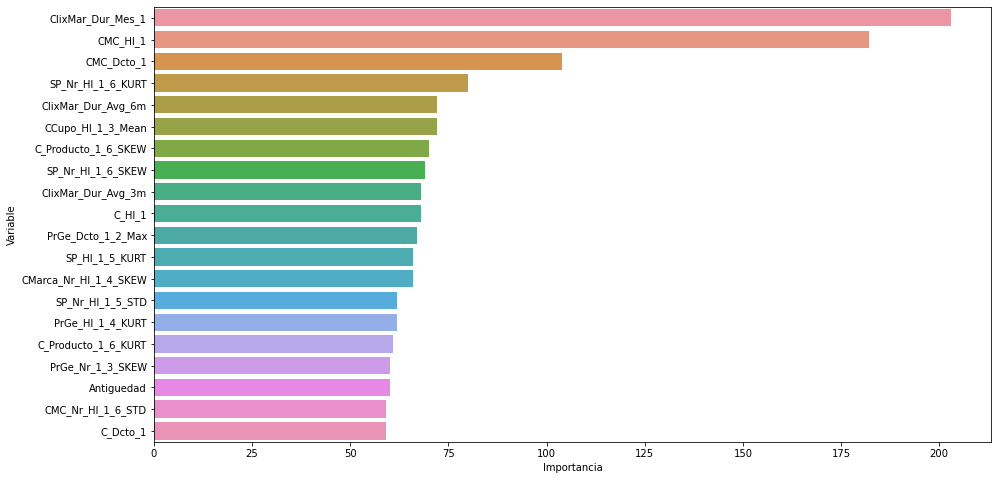

In [94]:
plt.figure(figsize=(15,8))
sns.barplot(x="Importancia", y="Variable", data=feature_imp.head(20))

Predicciones

In [95]:
prediccion_lgb_test = modelo_lgb.predict(X_test, num_iteration=modelo_lgb.best_iteration)
prediccion_lgb_train = modelo_lgb.predict(X_train, num_iteration=modelo_lgb.best_iteration)

In [99]:
prediccion_lgb_submit = modelo_lgb.predict(X_predict, num_iteration=modelo_lgb.best_iteration)

In [100]:
prediccion_lgb_test.min(), prediccion_lgb_test.mean(), prediccion_lgb_test.max()

(0.00014156182761166085, 0.24988156600826317, 0.9835706975003222)

In [101]:
prediccion_lgb_submit.min(), prediccion_lgb_submit.mean(), prediccion_lgb_submit.max()

(0.00018958077080438157, 0.27026517718923154, 0.9613983922657197)

AUC

In [96]:
print('AUC TEST: ',roc_auc_score(y_test, prediccion_lgb_test))
print('AUC TRAIN: ',roc_auc_score(y_train, prediccion_lgb_train))

AUC TEST:  0.9186578728088701
AUC TRAIN:  0.9523128862071529


Submit

In [102]:
submit = generar_submit(prediccion_lgb_submit)

In [103]:
submit.head()

,Cliente,Marca,Cupo,Ejecuto_Promo
0,10,40,16,0.900511
1,17,29,9,0.576566
2,37,29,9,0.051136
3,46,29,9,0.536026
4,48,29,9,0.053857


In [104]:
submit.to_csv('../Data/Submit/Submit_v73.csv',index=False)

## 4.2 LigthGBM - Variables importantes

In [106]:
variables_importante = list(feature_imp.head(100).Variable)

In [107]:
train_data = lgb.Dataset(X_train[variables_importante] , label=y_train)
test_data = lgb.Dataset(X_test[variables_importante], label=y_test)

In [114]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth':4,
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 100,#31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 60,
    'learning_rate': 0.03,
    'verbose': -1,
    'is_unbalance':'true'
}

In [115]:
modelo_lgb_imp = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=2000,
                       early_stopping_rounds=100, verbose_eval=100)

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=0.85 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1 will be ignored. Current value: bagging_fraction=0.85
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.914665
[200]	valid_0's auc: 0.916317
[300]	valid_0's auc: 0.91638
Early stopping, best iteration is:
[271]	valid_0's auc: 0.916567


Predicciones

In [116]:
prediccion_lgb_test = modelo_lgb_imp.predict(X_test[variables_importante], num_iteration=modelo_lgb_imp.best_iteration)
prediccion_lgb_train = modelo_lgb_imp.predict(X_train[variables_importante], num_iteration=modelo_lgb_imp.best_iteration)

In [117]:
prediccion_lgb_submit = modelo_lgb_imp.predict(X_predict[variables_importante], num_iteration=modelo_lgb.best_iteration)

Submit

In [118]:
submit = generar_submit(prediccion_lgb_submit)

In [119]:
submit.to_csv('../Data/Submit/Submit_v75.csv',index=False)

## 4.3 XGBoost

In [121]:
import xgboost as xgb

Definimos la matriz

In [123]:
data_train = xgb.DMatrix(X_train, y_train)
data_test = xgb.DMatrix(X_test , y_test)

evallist = [(data_test, 'validation'), (data_train, 'train')]

Definimos los parámetros

In [124]:
param = {
        # General Parameters
        'booster': 'gbtree',
        # Parameters for Tree Booster
        'eta': 0.05,
        'gamma': 0,
        'max_depth': 4, 
        'min_child_weight': 5,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        # Learning Task Parameters
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'seed': 1,
        'debug_verbose':0,
        'silent':1 
        }
num_round = 250 

In [125]:
modelo_xgb = xgb.train(param, data_train, num_round, evallist,verbose_eval=10,early_stopping_rounds=10)

[0]	validation-auc:0.88248	train-auc:0.88997
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[10]	validation-auc:0.90424	train-auc:0.91387
[20]	validation-auc:0.90601	train-auc:0.91631
[30]	validation-auc:0.91220	train-auc:0.92223
[40]	validation-auc:0.91280	train-auc:0.92404
[50]	validation-auc:0.91355	train-auc:0.92567
[60]	validation-auc:0.91446	train-auc:0.92710
[70]	validation-auc:0.91500	train-auc:0.92832
[80]	validation-auc:0.91548	train-auc:0.92959
[90]	validation-auc:0.91622	train-auc:0.93088
[100]	validation-auc:0.91630	train-auc:0.93190
[110]	validation-auc:0.91634	train-auc:0.93285
[120]	validation-auc:0.91658	train-auc:0.93387
[130]	validation-auc:0.91676	train-auc:0.93495
[140]	validation-auc:0.91693	train-auc:0.93641
[150]	validation-auc:0.91706	train-auc:0.93782
[160]	validation-auc:0.91711	train-auc:0.93905
[170]	validation-auc:0.91738	train-auc:0.94029
[180]	validation-auc:0

Variable importantes

<Figure size 2880x1440 with 0 Axes>

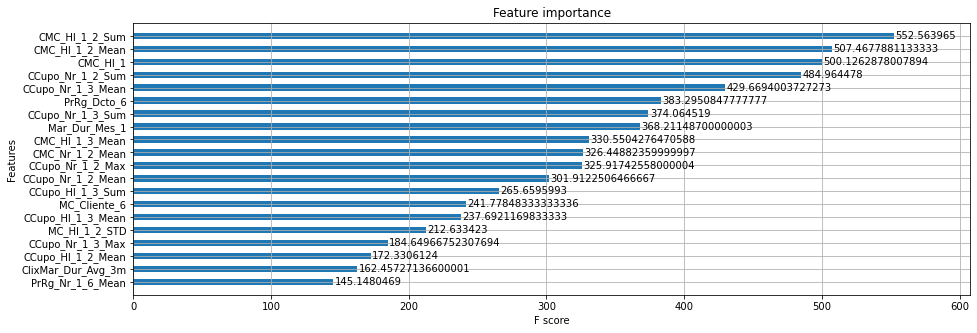

In [126]:
plt.figure(figsize=(40,20))
xgb.plot_importance(modelo_xgb,height=0.5,max_num_features=20,importance_type='gain')

In [127]:
feature_important = modelo_xgb.get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False).reset_index()

Predicciones

In [128]:
predict_train_xgb = modelo_xgb.predict(xgb.DMatrix(X_train),ntree_limit=modelo_xgb.best_iteration)
predict_test_xgb = modelo_xgb.predict(xgb.DMatrix(X_test),ntree_limit=modelo_xgb.best_iteration)

In [129]:
predict_submit_xgboost = modelo_xgb.predict(xgb.DMatrix(X_predict),ntree_limit=modelo_xgb.best_iteration)

Submit

In [130]:
submit_csv_xgb = generar_submit(predict_submit_xgboost)

In [131]:
submit_csv_xgb.to_csv('../Data/Submit/Submit_v76.csv',index=False)

## 4.4 XGBoost - Variables importantes

In [132]:
variables_importantes = data['index'].head(100)

In [133]:
data_train = xgb.DMatrix(X_train[variables_importantes], y_train)
data_test = xgb.DMatrix(X_test[variables_importantes], y_test)

evallist = [(data_test, 'validation'), (data_train, 'train')]

In [134]:
param = {
        # General Parameters
        'booster': 'gbtree',
        #'num_class': 2, 
        # Parameters for Tree Booster
        'eta': 0.05,
        'gamma': 0,
        'max_depth': 4, 
        'min_child_weight': 5,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        # Learning Task Parameters
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'seed': 1,
        'debug_verbose':0,
        # Balanced
        #'scale_pos_weight': 7.876724137931035,
        'silent':1 
        }
num_round = 400

In [135]:
modelo_xgb_imp = xgb.train(param, data_train, num_round, evallist,verbose_eval=10,early_stopping_rounds=10)

[0]	validation-auc:0.88047	train-auc:0.88841
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[10]	validation-auc:0.90392	train-auc:0.91147
[20]	validation-auc:0.90617	train-auc:0.91473
[30]	validation-auc:0.91116	train-auc:0.91973
[40]	validation-auc:0.91262	train-auc:0.92205
[50]	validation-auc:0.91354	train-auc:0.92338
[60]	validation-auc:0.91425	train-auc:0.92441
[70]	validation-auc:0.91482	train-auc:0.92532
[80]	validation-auc:0.91517	train-auc:0.92614
[90]	validation-auc:0.91553	train-auc:0.92692
[100]	validation-auc:0.91574	train-auc:0.92753
[110]	validation-auc:0.91583	train-auc:0.92810
[120]	validation-auc:0.91607	train-auc:0.92859
[130]	validation-auc:0.91625	train-auc:0.92920
[140]	validation-auc:0.91656	train-auc:0.93010
[150]	validation-auc:0.91681	train-auc:0.93109
[160]	validation-auc:0.91693	train-auc:0.93187
[170]	validation-auc:0.91704	train-auc:0.93255
[180]	validation-auc:0

Predicciones

In [136]:
predict_train_xgb = modelo_xgb_imp.predict(xgb.DMatrix(X_train[variables_importantes]),ntree_limit=modelo_xgb_imp.best_iteration)
predict_test_xgb = modelo_xgb_imp.predict(xgb.DMatrix(X_test[variables_importantes]),ntree_limit=modelo_xgb_imp.best_iteration)

In [138]:
predict_submit_xgboost = modelo_xgb_imp.predict(xgb.DMatrix(X_predict[variables_importantes]),ntree_limit=modelo_xgb.best_iteration)

Submit

In [139]:
submit_csv_xgb = generar_submit(predict_submit_xgboost)

In [140]:
submit_csv_xgb.to_csv('../Data/Submit/Submit_v77.csv',index=False)